In [1]:
import pandas as pd
from feature_engine.datetime import DatetimeFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import os
import pickle
import numpy as np
import warnings
import pandas as pd
from feature_engine.encoding import MeanEncoder, OneHotEncoder, OrdinalEncoder
from feature_engine.imputation import (
    ArbitraryNumberImputer,
    CategoricalImputer,
    MeanMedianImputer,
)
from feature_engine.selection import DropConstantFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sktime.transformations.series.summarize import WindowSummarizer
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import WindowFeatures, LagFeatures

import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# for this feature

sns.set_context("talk")

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
CATEGORICAL_COLUMNS = ["holiday_name"]
NUMERICAL_COLUMNS = [
    "holiday",
    "shutdown",
    "mini_shutdown",
    "shops_closed",
    "winter_school_holidays",
    "school_holidays",
    "blackout",
    "mov_change",
    "frankfurt_shutdown",
    "year",
    "month",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "weekend",
]
DATE_COLUMNS = ["date"]

TARGET_COLUMNS = "orders"
FEATRURE_COLUMNS = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS  # + DATE_COLUMNS
TRAIN_LEVEL = ["warehouse"]
MODEL_PATH = "model_registry"

In [3]:
# load the data
PATH = "./data/"
df_train = pd.read_csv(f"{PATH}train_new.csv", parse_dates=["date"], index_col="date")
df_train["split"] = "train"

df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
df_test["split"] = "test"

cols = df_train.columns
df_test = df_test[cols]

# df = pd.concat([df_train, df_test], axis=0)

# df = pd.concat([df_train, df_test], axis=0)

In [4]:
df_test.head()

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-16,0,2024,3,16,5,76,1,test
2024-03-17,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-17,0,2024,3,17,6,77,1,test
2024-03-18,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-18,0,2024,3,18,0,78,0,test
2024-03-19,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-19,0,2024,3,19,1,79,0,test
2024-03-20,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-20,0,2024,3,20,2,80,0,test


In [5]:
warehouse = df_train["warehouse"].unique()[5]
print(f"Warehouse: {warehouse}")
df_train = df_train.query(
    f"warehouse== '{warehouse}' and not {TARGET_COLUMNS}.isnull()"
)
df_test = df_test.query(f"warehouse== '{warehouse}'")
df = pd.concat([df_train, df_test], axis=0)
df_predict_all = pd.concat([df_train.iloc[-365:, :], df_test], axis=0)

Warehouse: Frankfurt_1


In [6]:
# set the frequency of the time series to daily
# df_train.index.freq = "D"
# df_test.index.freq = "D"

# df_train.set_index("date", inplace=True,)
# df_test.set_index("date", inplace=True)

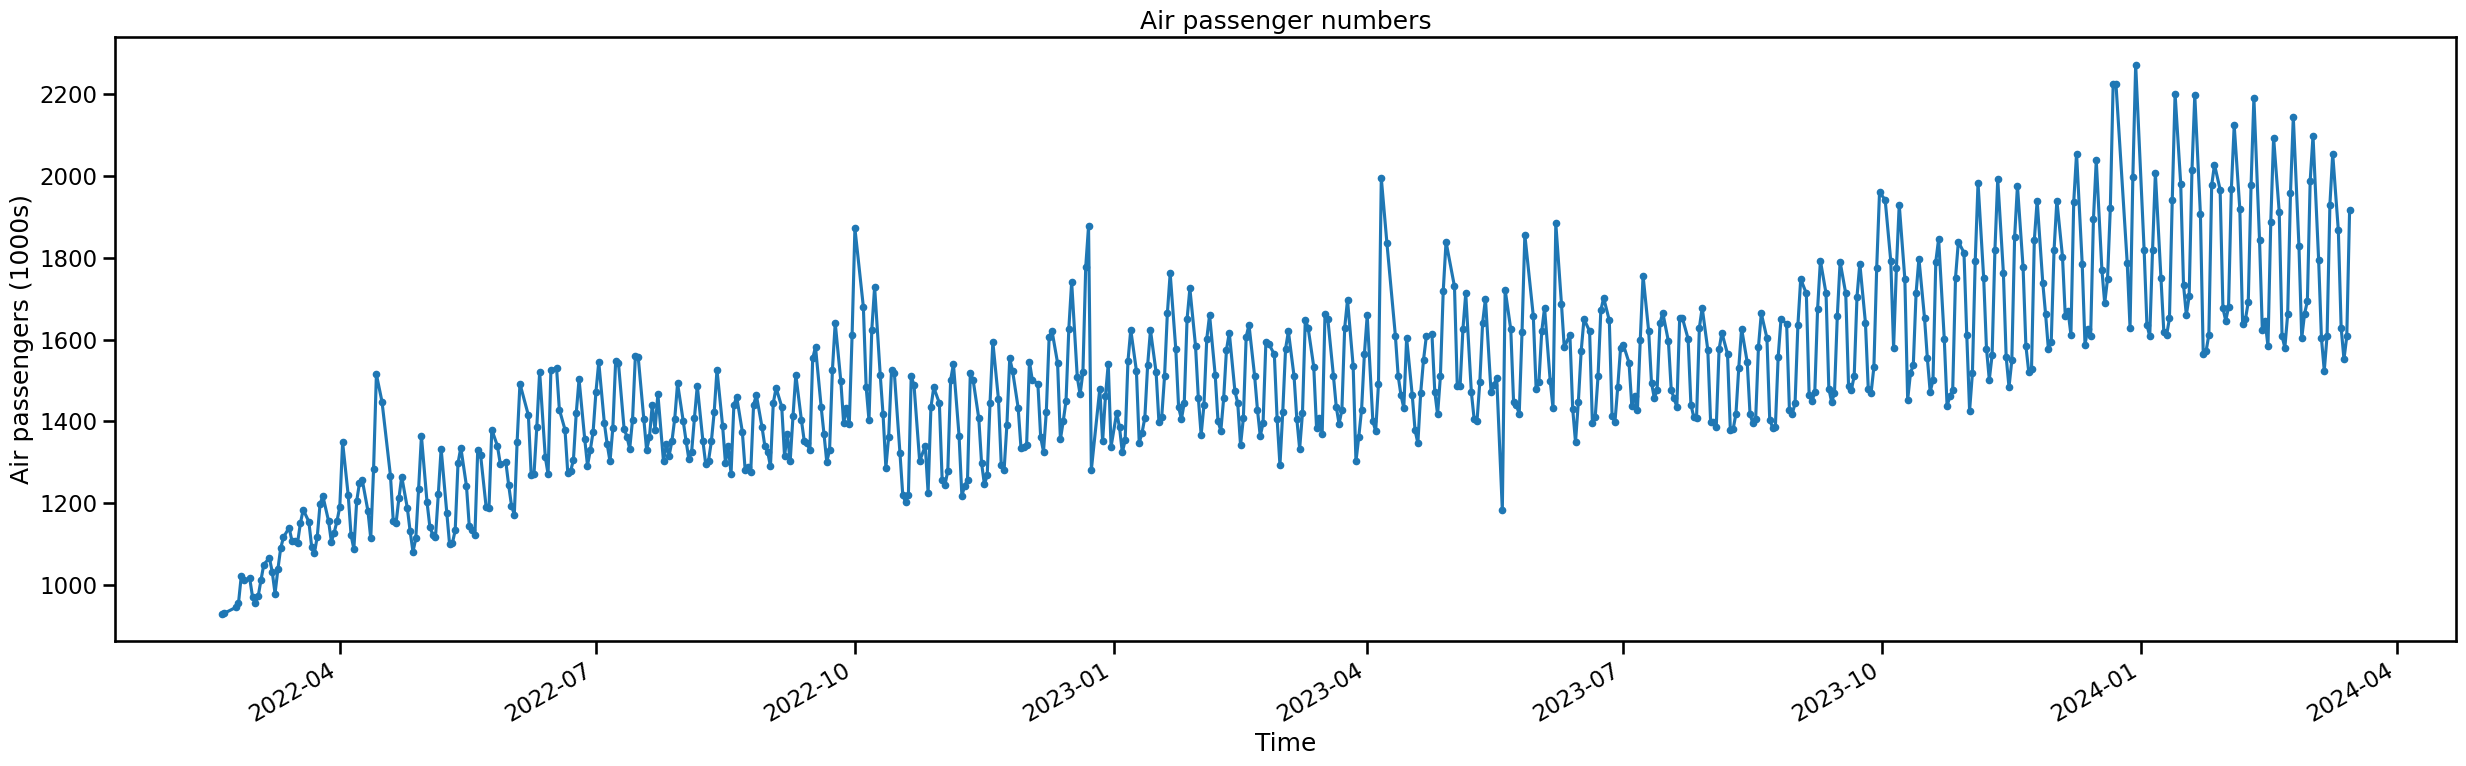

In [7]:
fig, ax = plt.subplots(figsize=[25, 7])
df_train.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
# df_test.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

In [8]:
pipeline = Pipeline(
    [
        # ('drop_na_lags', DropMissingData(variables=new_cols)),
        # Impute missing categorical except mean-encoded ones, normally happens in the test data
        (
            "missing_categoricals",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_COLUMNS
            ),
        ),
        # Impute 0 for missing numericals
        (
            "missing_numerical",
            ArbitraryNumberImputer(variables=NUMERICAL_COLUMNS, arbitrary_number=0),
        ),
        # OneHotEncode the rest of categorical
        (
            "onehot_encoding",
            OneHotEncoder(
                top_categories=6,
                variables=CATEGORICAL_COLUMNS,
                ignore_format=True,
            ),
        ),
        # Drop Constant features
        ("drop_constant", DropConstantFeatures(tol=1)),
        ("xgb", XGBRegressor(n_estimators=100, random_state=42)),
    ]
)

In [9]:
pipeline_lags = Pipeline(
    [
        (
            "lag_window",
            # Create window features using the transformer.
            WindowFeatures(
                variables=[TARGET_COLUMNS],
                functions=["mean"],
                window=[7],  # Day, week, year.
                freq="D",
                missing_values="ignore",
            ),
        ),
        (
            "lag_features",
            LagFeatures(
                variables=[TARGET_COLUMNS],
                periods=[1, 7, 365],
                freq="D",
                missing_values="ignore",
            ),
        ),
    ]
)

In [10]:
df_train = df.query("split=='train'")[FEATRURE_COLUMNS + [TARGET_COLUMNS]].copy()
df_test = df.query("split=='test'")[FEATRURE_COLUMNS + [TARGET_COLUMNS]].copy()
df_predict = df_predict_all.copy()

print(df_train.shape, df_test.shape)

df_train_lags = pipeline_lags.fit_transform(df_train)
print(df_train_lags.shape)

new_cols = [col for col in df_train_lags.columns if col not in df_train.columns]
new_cols
df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
print(df_train_lags.shape)

X_train = df_train_lags[FEATRURE_COLUMNS + new_cols]
y_train = df_train_lags[TARGET_COLUMNS]

print(X_train.shape, y_train.shape)

model = pipeline.fit(X_train, y_train)

(629, 17) (61, 17)
(629, 19)
(508, 19)
(508, 18) (508,)


In [11]:
# forecast_time = df_train.index.max() + datetime.timedelta(days=1)
# forecast_time

In [12]:
for forecast_time in df_test.index:
    print(f"Forecasting for {forecast_time}")
    # print(df_predict[:forecast_time].shape)
    X_test = pipeline_lags.transform(
        df_predict[FEATRURE_COLUMNS + [TARGET_COLUMNS]][:forecast_time]
    )
    X_test_ = X_test.loc[[forecast_time]]

    y_pred = model.predict(X_test_[FEATRURE_COLUMNS + new_cols])
    # print(f"Predicted: {y_pred}")

    df_predict.loc[[forecast_time], TARGET_COLUMNS] = y_pred

Forecasting for 2024-03-16 00:00:00
Forecasting for 2024-03-17 00:00:00
Forecasting for 2024-03-18 00:00:00
Forecasting for 2024-03-19 00:00:00
Forecasting for 2024-03-20 00:00:00
Forecasting for 2024-03-21 00:00:00
Forecasting for 2024-03-22 00:00:00
Forecasting for 2024-03-23 00:00:00
Forecasting for 2024-03-24 00:00:00
Forecasting for 2024-03-25 00:00:00
Forecasting for 2024-03-26 00:00:00
Forecasting for 2024-03-27 00:00:00
Forecasting for 2024-03-28 00:00:00
Forecasting for 2024-03-29 00:00:00
Forecasting for 2024-03-30 00:00:00
Forecasting for 2024-03-31 00:00:00
Forecasting for 2024-04-01 00:00:00
Forecasting for 2024-04-02 00:00:00
Forecasting for 2024-04-03 00:00:00
Forecasting for 2024-04-04 00:00:00
Forecasting for 2024-04-05 00:00:00
Forecasting for 2024-04-06 00:00:00
Forecasting for 2024-04-07 00:00:00
Forecasting for 2024-04-08 00:00:00
Forecasting for 2024-04-09 00:00:00
Forecasting for 2024-04-10 00:00:00
Forecasting for 2024-04-11 00:00:00
Forecasting for 2024-04-12 0

In [13]:
df_predict

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,Frankfurt_1,1324.000000,no_holiday,0,0,0,0,1,0,0,...,0,Frankfurt_1_2023-01-04,0,2023,1,4,2,4,0,train
2023-01-05,Frankfurt_1,1354.000000,no_holiday,0,0,0,0,1,0,0,...,0,Frankfurt_1_2023-01-05,0,2023,1,5,3,5,0,train
2023-01-06,Frankfurt_1,1547.000000,no_holiday,0,0,0,0,1,0,0,...,0,Frankfurt_1_2023-01-06,0,2023,1,6,4,6,0,train
2023-01-07,Frankfurt_1,1624.000000,no_holiday,0,0,0,0,1,0,0,...,0,Frankfurt_1_2023-01-07,0,2023,1,7,5,7,1,train
2023-01-09,Frankfurt_1,1524.000000,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2023-01-09,0,2023,1,9,0,9,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11,Frankfurt_1,2102.315186,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-11,0,2024,5,11,5,132,1,test
2024-05-12,Frankfurt_1,2176.187988,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-12,1,2024,5,12,6,133,1,test
2024-05-13,Frankfurt_1,1696.903931,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-13,0,2024,5,13,0,134,0,test


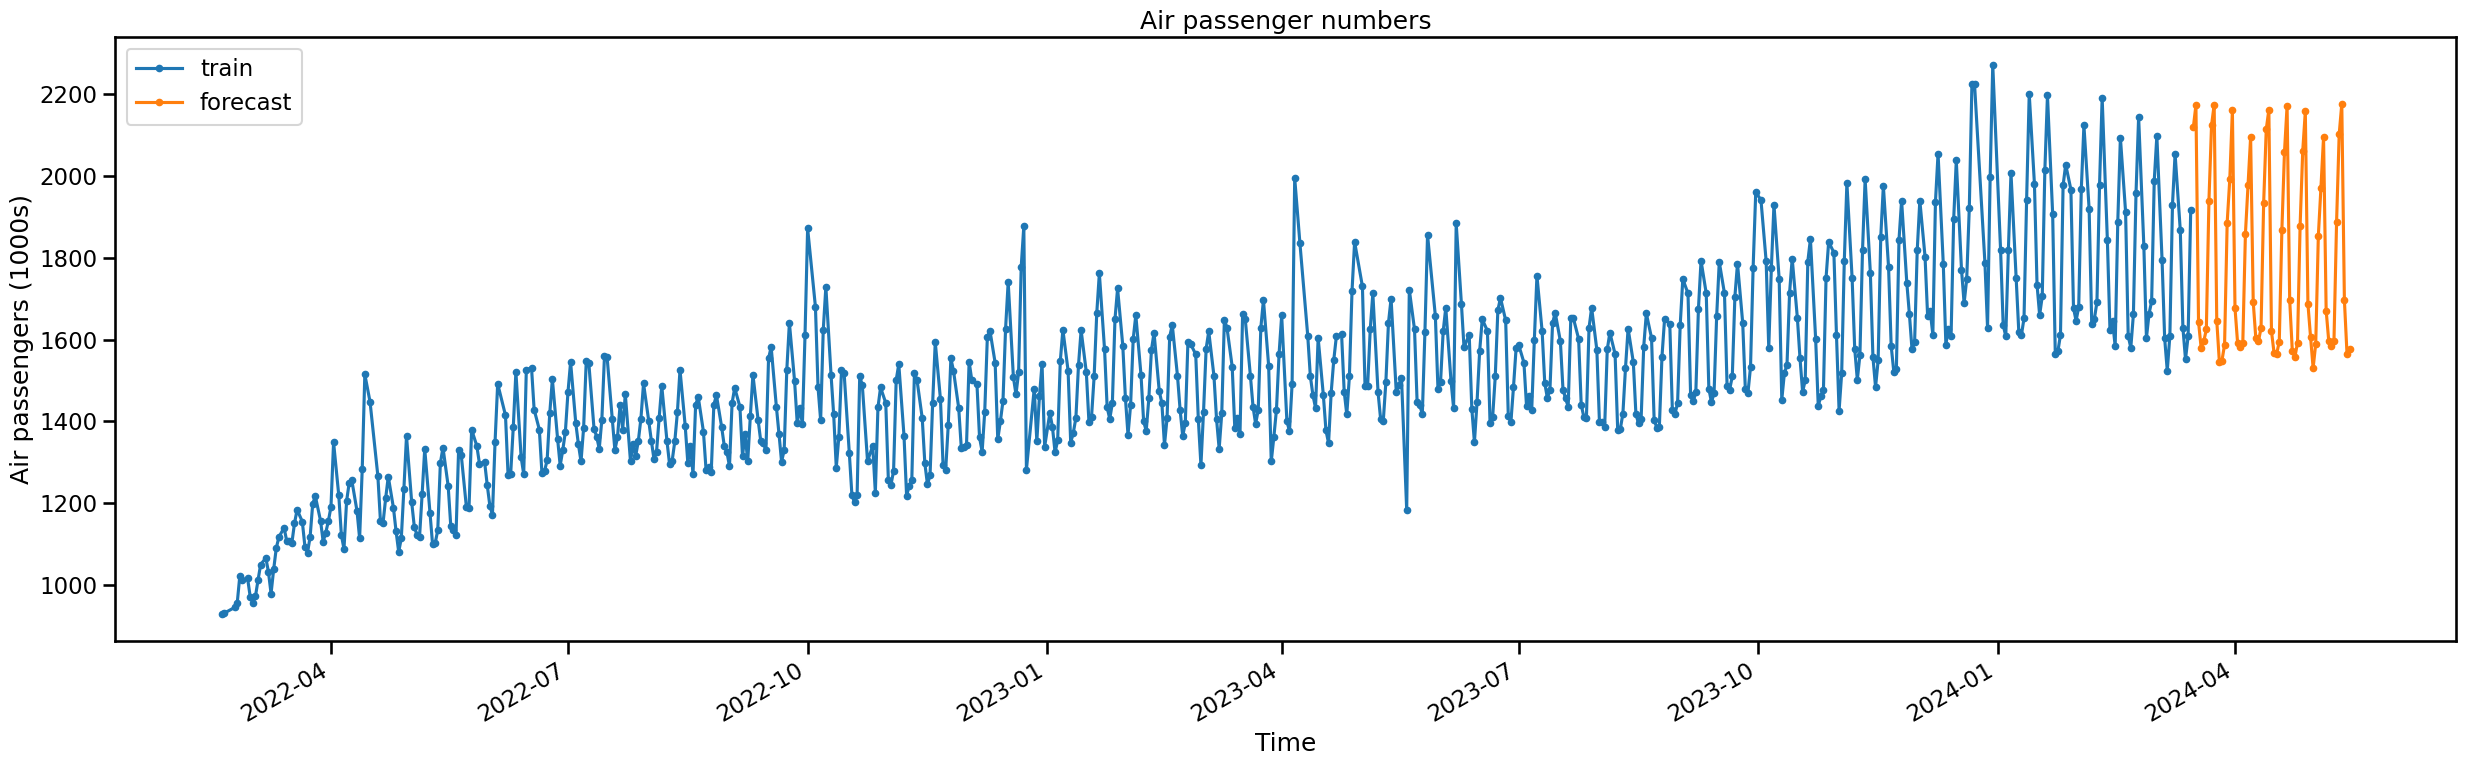

In [14]:
fig, ax = plt.subplots(figsize=[25, 7])
df_train.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
df_predict.query("split=='test'").plot(
    y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax
)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
ax.legend(["train", "forecast"])
plt.tight_layout()

In [15]:
def train_predict(df, feature_columns, target_columns, max_lag=365, pipeline=None, pipeline_lags=None):

    print(f"warehouse: {df.warehouse.unique()[0]}")

    df_train = df.query(f"split=='train'")[feature_columns + [target_columns]].copy()
    df_test = df.query("split=='test'")[feature_columns + [target_columns]].copy()
    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=max_lag)))
        )
    ]

    # df_predict = pd.concat([df_train.iloc[-365:, :], df_test], axis=0)
    # df_predict = df_predict_all.copy()

    print("Shape of df_train and df_test before lag transformation",df_train.shape, df_test.shape)

    df_train_lags = pipeline_lags.fit_transform(df_train)
    print("Shape of df_train after lag transformation", df_train_lags.shape)

    new_cols = [col for col in df_train_lags.columns if col not in df_train.columns]
    
    df_train_lags.dropna(subset=new_cols+[target_columns], how="any", inplace=True)
    print("Shape of df_train after droping the nulls", df_train_lags.shape)

    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags[target_columns]

    print("Shape of X_train and y_train after droping the nulls", X_train.shape, y_train.shape)

    model = pipeline.fit(X_train, y_train)

    for forecast_time in df_test.index:
        # print(f"Forecasting for {forecast_time}")
        # print(df_predict[:forecast_time].shape)
        df_predcit_ = df_predict[feature_columns + [target_columns]].loc[:forecast_time]
        # print(df_predcit_.shape)
        X_test = pipeline_lags.transform(df_predcit_)
        X_test_ = X_test.loc[[forecast_time]]

        y_pred = model.predict(X_test_[feature_columns + new_cols])
        # print(f"Predicted: {y_pred}")

        df_predict.loc[[forecast_time], target_columns] = y_pred

    return df_predict.query("split=='test'")

In [16]:
train_predict(df, FEATRURE_COLUMNS, TARGET_COLUMNS, max_lag=365, pipeline=pipeline, pipeline_lags=pipeline_lags)

warehouse: Frankfurt_1
Shape of df_train and df_test before lag transformation (629, 17) (61, 17)
Shape of df_train after lag transformation (629, 19)
Shape of df_train after droping the nulls (508, 19)
Shape of X_train and y_train after droping the nulls (508, 18) (508,)


,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,Frankfurt_1,2184.312012,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-16,0,2024,3,16,5,76,1,test
2024-03-17,Frankfurt_1,1881.001953,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-17,1,2024,3,17,6,77,1,test
2024-03-18,Frankfurt_1,1517.264160,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-18,0,2024,3,18,0,78,0,test
2024-03-19,Frankfurt_1,1452.567627,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-19,0,2024,3,19,1,79,0,test
2024-03-20,Frankfurt_1,1436.905518,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-20,0,2024,3,20,2,80,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11,Frankfurt_1,1701.973999,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-11,0,2024,5,11,5,132,1,test
2024-05-12,Frankfurt_1,1789.522095,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-12,1,2024,5,12,6,133,1,test
2024-05-13,Frankfurt_1,1506.917236,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-13,0,2024,5,13,0,134,0,test


# second method using SKtime

In [17]:
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365,7]],  # [[lag, window size]]
    },
    target_cols='y',
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [18]:
df.rename(columns={TARGET_COLUMNS: "y"}, inplace=True)
df_train = df.query("split=='train'")[FEATRURE_COLUMNS + ['y']].copy()
df_test = df.query("split=='test'")[FEATRURE_COLUMNS + ['y']].copy()
df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=7)))
        )
    ]

# df_predict = pd.concat([df_train.iloc[-365:, :], df_test], axis=0)

In [19]:
df_train_lags_only = lag_window_feats.fit_transform(df_train[['y']])
df_train_lags = pd.concat([df_train, df_train_lags_only], axis=1)

new_cols = list(df_train_lags_only.columns)

df_train_lags.dropna(subset=new_cols, how="any", inplace=True)

X_train = df_train_lags[FEATRURE_COLUMNS + new_cols]
y_train = df_train_lags['y']

model = pipeline.fit(X_train, y_train)

In [20]:
for forecast_time in df_test.index:
    print(f"Forecasting for {forecast_time}")
    # print(df_predict[:forecast_time].shape)
    # X_test = pipeline_lags.transform(
    #     df_predict[FEATRURE_COLUMNS + ['y']][:forecast_time]
    # )
    df_predict_lags_only = lag_window_feats.transform(df_predict[['y']])
    X_test = pd.concat([df_predict, df_predict_lags_only], axis=1)

    X_test_ = X_test.loc[[forecast_time]]

    y_pred = model.predict(X_test_[FEATRURE_COLUMNS + new_cols])
    # print(f"Predicted: {y_pred}")

    df_predict.loc[[forecast_time], 'y'] = y_pred

df_train.rename(columns={'y': TARGET_COLUMNS}, inplace=True)
df_test.rename(columns={'y': TARGET_COLUMNS}, inplace=True)
df_predict.rename(columns={'y': TARGET_COLUMNS}, inplace=True)

Forecasting for 2024-03-16 00:00:00
Forecasting for 2024-03-17 00:00:00
Forecasting for 2024-03-18 00:00:00
Forecasting for 2024-03-19 00:00:00
Forecasting for 2024-03-20 00:00:00
Forecasting for 2024-03-21 00:00:00
Forecasting for 2024-03-22 00:00:00
Forecasting for 2024-03-23 00:00:00
Forecasting for 2024-03-24 00:00:00
Forecasting for 2024-03-25 00:00:00
Forecasting for 2024-03-26 00:00:00
Forecasting for 2024-03-27 00:00:00
Forecasting for 2024-03-28 00:00:00
Forecasting for 2024-03-29 00:00:00
Forecasting for 2024-03-30 00:00:00
Forecasting for 2024-03-31 00:00:00
Forecasting for 2024-04-01 00:00:00
Forecasting for 2024-04-02 00:00:00
Forecasting for 2024-04-03 00:00:00
Forecasting for 2024-04-04 00:00:00
Forecasting for 2024-04-05 00:00:00
Forecasting for 2024-04-06 00:00:00
Forecasting for 2024-04-07 00:00:00
Forecasting for 2024-04-08 00:00:00
Forecasting for 2024-04-09 00:00:00
Forecasting for 2024-04-10 00:00:00
Forecasting for 2024-04-11 00:00:00
Forecasting for 2024-04-12 0

C:\Users\alire\AppData\Local\Temp\ipykernel_12128\767589434.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict.rename(columns={'y': TARGET_COLUMNS}, inplace=True)


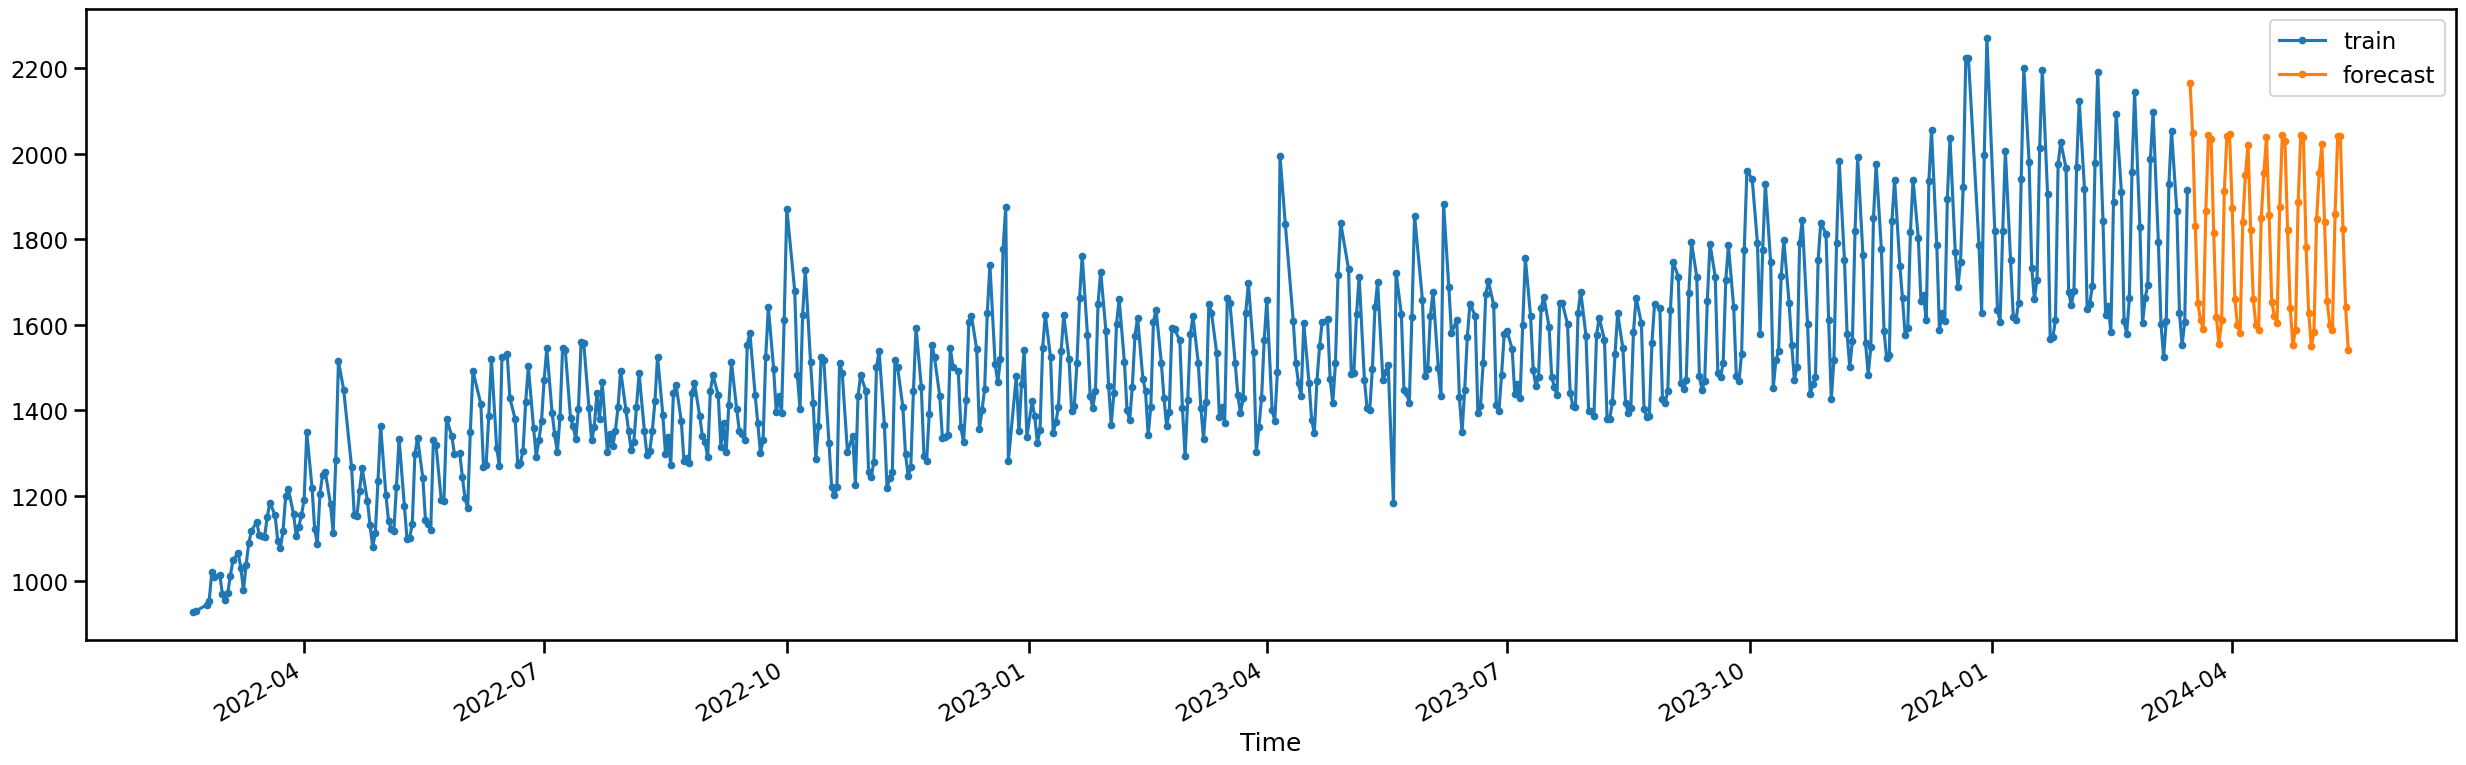

In [21]:
fig, ax = plt.subplots(figsize=[25, 7])
df_train.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
df_predict.query("split=='test'").plot(
    y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax
)
ax.set_xlabel("Time")
# ax.set_ylabel("Air passengers (1000s)")
# ax.set_title("Air passenger numbers")
ax.legend(["train", "forecast"])
plt.tight_layout()

In [22]:
def train_predict_sktime(df, feature_columns, target_columns, max_lag=365, pipeline=None, pipeline_lags_transformer=None):
    
    print(f"warehouse: {df.warehouse.unique()[0]}")

    df.rename(columns={target_columns: "y"}, inplace=True)
    df_train = df.query("split=='train'")[feature_columns + ['y']].copy()
    df_test = df.query("split=='test'")[feature_columns + ['y']].copy()
    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=max_lag)))
        )
    ]

    df_train_lags_only = pipeline_lags_transformer.fit_transform(df_train[['y']])
    df_train_lags = pd.concat([df_train, df_train_lags_only], axis=1)

    new_cols = list(df_train_lags_only.columns)
    df_train_lags.dropna(subset=new_cols+['y'], how="any", inplace=True)

    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags['y']

    model = pipeline.fit(X_train, y_train)
    
    for forecast_time in df_test.index:
        # print(f"Forecasting for {forecast_time}")
        
        df_predict_lags_only = pipeline_lags_transformer.transform(df_predict[['y']])
        X_test = pd.concat([df_predict, df_predict_lags_only], axis=1)

        X_test_ = X_test.loc[[forecast_time]]

        y_pred = model.predict(X_test_[feature_columns + new_cols])

        df_predict.loc[[forecast_time], 'y'] = y_pred

    df_predict.rename(columns={'y': target_columns}, inplace=True)
    
    return df_predict.query("split=='test'")

In [23]:
train_predict_sktime(df, FEATRURE_COLUMNS, TARGET_COLUMNS, max_lag=365, pipeline=pipeline, pipeline_lags_transformer=lag_window_feats)

warehouse: Frankfurt_1


C:\Users\alire\AppData\Local\Temp\ipykernel_12128\3182744278.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict.rename(columns={'y': target_columns}, inplace=True)


,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,Frankfurt_1,2167.113037,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-16,0,2024,3,16,5,76,1,test
2024-03-17,Frankfurt_1,2048.169678,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-17,1,2024,3,17,6,77,1,test
2024-03-18,Frankfurt_1,1830.347168,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-18,0,2024,3,18,0,78,0,test
2024-03-19,Frankfurt_1,1651.385742,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-19,0,2024,3,19,1,79,0,test
2024-03-20,Frankfurt_1,1611.029663,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-03-20,0,2024,3,20,2,80,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11,Frankfurt_1,2042.925171,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-11,0,2024,5,11,5,132,1,test
2024-05-12,Frankfurt_1,2041.937622,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-12,1,2024,5,12,6,133,1,test
2024-05-13,Frankfurt_1,1824.922974,no_holiday,0,0,0,0,0,0,0,...,0,Frankfurt_1_2024-05-13,0,2024,5,13,0,134,0,test


# for all the data

In [24]:
# load the data
PATH = "./data/"
df_train = pd.read_csv(f"{PATH}train_new.csv", parse_dates=["date"], index_col="date")
df_train["split"] = "train"

df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
df_test["split"] = "test"

cols = df_train.columns
df_test = df_test[cols]

df = pd.concat([df_train, df_test], axis=0)

In [25]:
df.query("warehouse!='Frankfurt_1'").groupby(TRAIN_LEVEL).apply(
    train_predict, FEATRURE_COLUMNS, TARGET_COLUMNS, max_lag=365, pipeline=pipeline, pipeline_lags=pipeline_lags
)

warehouse: Brno_1
Shape of df_train and df_test before lag transformation (1197, 17) (61, 17)
Shape of df_train after lag transformation (1197, 19)
Shape of df_train after droping the nulls (1158, 19)
Shape of X_train and y_train after droping the nulls (1158, 18) (1158,)
warehouse: Budapest_1
Shape of df_train and df_test before lag transformation (1196, 17) (61, 17)
Shape of df_train after lag transformation (1196, 19)
Shape of df_train after droping the nulls (949, 19)
Shape of X_train and y_train after droping the nulls (949, 18) (949,)
warehouse: Munich_1
Shape of df_train and df_test before lag transformation (969, 17) (61, 17)
Shape of df_train after lag transformation (969, 19)
Shape of df_train after droping the nulls (20, 19)
Shape of X_train and y_train after droping the nulls (20, 18) (20,)
warehouse: Prague_1
Shape of df_train and df_test before lag transformation (1197, 17) (61, 17)
Shape of df_train after lag transformation (1197, 19)
Shape of df_train after droping the 

warehouse       orders holiday_name  holiday  shutdown  \
warehouse date                                                                
Brno_1    2024-03-16    Brno_1  9848.380859   no_holiday        0         0   
          2024-03-17    Brno_1  7514.254883   no_holiday        0         0   
          2024-03-18    Brno_1  7370.350586   no_holiday        0         0   
          2024-03-19    Brno_1  7193.284668   no_holiday        0         0   
          2024-03-20    Brno_1  7270.015137   no_holiday        0         0   
...                        ...          ...          ...      ...       ...   
Prague_3  2024-05-11  Prague_3  4883.416016   no_holiday        0         0   
          2024-05-12  Prague_3  4706.266602   no_holiday        0         0   
          2024-05-13  Prague_3  4859.205078   no_holiday        0         0   
          2024-05-14  Prague_3  4704.096191   no_holiday        0         0   
          2024-05-15  Prague_3  4644.110352   no_holiday        0         0   

                      mini_shutdown  shops_closed  winter_school_holidays  \
warehouse date                                                              
Brno_1    2024-03-16              0             0                       0   
          2024-03-17              0             0                       0   
          2024-03-18              0             0                       0   
          2024-03-19              0             0                       0   
          2024-03-20              0             0                       0   
...                             ...           ...                     ...   
Prague_3  2024-05-11              0             0                       0   
          2024-05-12              0             0                       0   
          2024-05-13              0             0                       0   
          2024-05-14              0             0                       0   
          2024-05-15              0             0                       0   

                      school_holidays  blackout  ...  snow  \
warehouse date                                   ...         
Brno_1    2024-03-16                0         0  ...     0   
          2024-03-17                0         0  ...     0   
          2024-03-18                0         0  ...     0   
          2024-03-19                0         0  ...     0   
          2024-03-20                0         0  ...     0   
...                               ...       ...  ...   ...   
Prague_3  2024-05-11                0         0  ...     0   
          2024-05-12                0         0  ...     0   
          2024-05-13                0         0  ...     0   
          2024-05-14                0         0  ...     0   
          2024-05-15                0         0  ...     0   

                                       id  missing  year month  day_of_month  \
warehouse date                                                                 
Brno_1    2024-03-16    Brno_1_2024-03-16        0  2024     3            16   
          2024-03-17    Brno_1_2024-03-17        0  2024     3            17   
          2024-03-18    Brno_1_2024-03-18        0  2024     3            18   
          2024-03-19    Brno_1_2024-03-19        0  2024     3            19   
          2024-03-20    Brno_1_2024-03-20        0  2024     3            20   
...                                   ...      ...   ...   ...           ...   
Prague_3  2024-05-11  Prague_3_2024-05-11        0  2024     5            11   
          2024-05-12  Prague_3_2024-05-12        0  2024     5            12   
          2024-05-13  Prague_3_2024-05-13        0  2024     5            13   
          2024-05-14  Prague_3_2024-05-14        0  2024     5            14   
          2024-05-15  Prague_3_2024-05-15        0  2024     5            15   

                      day_of_week  day_of_year  weekend  split  
warehouse date                                                  
Brno_1    202

In [28]:
df.query("warehouse=='Frankfurt_1'").groupby(TRAIN_LEVEL).apply(
    train_predict, FEATRURE_COLUMNS, TARGET_COLUMNS, max_lag=365, pipeline=pipeline, pipeline_lags=pipeline_lags
)

warehouse: Frankfurt_1
Shape of df_train and df_test before lag transformation (757, 17) (61, 17)
Shape of df_train after lag transformation (757, 19)
Shape of df_train after droping the nulls (0, 19)
Shape of X_train and y_train after droping the nulls (0, 18) (0,)


ValueError: 0 feature(s) (shape=(0, 18)) while a minimum of 1 is required.

In [27]:
df.query("warehouse!='Munich_1' & warehouse!='Frankfurt_1'").groupby(TRAIN_LEVEL).apply(
    train_predict_sktime, FEATRURE_COLUMNS, TARGET_COLUMNS, max_lag=365, pipeline=pipeline, pipeline_lags_transformer=lag_window_feats
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


warehouse       orders holiday_name  holiday  shutdown  \
warehouse date                                                                
Brno_1    2024-03-16    Brno_1  9389.889648   no_holiday        0         0   
          2024-03-17    Brno_1  8234.446289   no_holiday        0         0   
          2024-03-18    Brno_1  8190.903320   no_holiday        0         0   
          2024-03-19    Brno_1  8387.393555   no_holiday        0         0   
          2024-03-20    Brno_1  8526.462891   no_holiday        0         0   
...                        ...          ...          ...      ...       ...   
Prague_3  2024-05-11  Prague_3  5998.629883   no_holiday        0         0   
          2024-05-12  Prague_3  5676.364258   no_holiday        0         0   
          2024-05-13  Prague_3  5146.570801   no_holiday        0         0   
          2024-05-14  Prague_3  5198.281738   no_holiday        0         0   
          2024-05-15  Prague_3  5077.535645   no_holiday        0         0   

                      mini_shutdown  shops_closed  winter_school_holidays  \
warehouse date                                                              
Brno_1    2024-03-16              0             0                       0   
          2024-03-17              0             0                       0   
          2024-03-18              0             0                       0   
          2024-03-19              0             0                       0   
          2024-03-20              0             0                       0   
...                             ...           ...                     ...   
Prague_3  2024-05-11              0             0                       0   
          2024-05-12              0             0                       0   
          2024-05-13              0             0                       0   
          2024-05-14              0             0                       0   
          2024-05-15              0             0                       0   

                      school_holidays  blackout  ...  snow  \
warehouse date                                   ...         
Brno_1    2024-03-16                0         0  ...     0   
          2024-03-17                0         0  ...     0   
          2024-03-18                0         0  ...     0   
          2024-03-19                0         0  ...     0   
          2024-03-20                0         0  ...     0   
...                               ...       ...  ...   ...   
Prague_3  2024-05-11                0         0  ...     0   
          2024-05-12                0         0  ...     0   
          2024-05-13                0         0  ...     0   
          2024-05-14                0         0  ...     0   
          2024-05-15                0         0  ...     0   

                                       id  missing  year month  day_of_month  \
warehouse date                                                                 
Brno_1    2024-03-16    Brno_1_2024-03-16        0  2024     3            16   
          2024-03-17    Brno_1_2024-03-17        0  2024     3            17   
          2024-03-18    Brno_1_2024-03-18        0  2024     3            18   
          2024-03-19    Brno_1_2024-03-19        0  2024     3            19   
          2024-03-20    Brno_1_2024-03-20        0  2024     3            20   
...                                   ...      ...   ...   ...           ...   
Prague_3  2024-05-11  Prague_3_2024-05-11        0  2024     5            11   
          2024-05-12  Prague_3_2024-05-12        0  2024     5            12   
          2024-05-13  Prague_3_2024-05-13        0  2024     5            13   
          2024-05-14  Prague_3_2024-05-14        0  2024     5            14   
          2024-05-15  Prague_3_2024-05-15        0  2024     5            15   

                      day_of_week  day_of_year  weekend  split  
warehouse date                                                  
Brno_1    202